# Amazon SageMaker Semantic Segmentation Algorithm

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Data Preparation](#Data-Preparation)
  1. [Download data](#Download-data)
  2. [Setup data](#Setup-data)
  3. [Upload to S3](#Upload-to-S3)
4. [Training](#Training)
5. [Deployment](#Deployment)
6. [Inference](#Inference)

## Introduction

Semantic Segmentation (SS) is the task of classifying every pixel in an image with a class from a known set of labels. In contrast, [image classification](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/imageclassification_caltech) generates only one label per image and [object detection](https://github.com/awslabs/amazon-sagemaker-examples/tree/master/introduction_to_amazon_algorithms/object_detection_pascalvoc_coco) generates a bounding box along with the label for each object in the image. The semantic segmentation output is usually represented as different pixel values in the image. Therefore, the output is an integer matrix (or a grayscale image) with the same shape as the input image. This output image is also called a segmentation mask. With the Amazon SageMaker Semantic Segmentation algorithm, not only can you train your models with your own dataset but also use our pre-trained models for lazy initialization.

This notebook is an end-to-end example introducing the Amazon SageMaker Semantic Segmentation algorithm. In this demo, we will demonstrate how to train and host a semantic segmentation model using the fully-convolutional network ([FCN](https://arxiv.org/abs/1605.06211)) algorithm using the [Pascal VOC dataset](http://host.robots.ox.ac.uk/pascal/VOC/) for training. Amazon SageMaker Semantic Segmentation also provides the option of using Pyramid Scene Parsing Network ([PSP](https://arxiv.org/abs/1612.01105)) and [Deeplab-v3](https://arxiv.org/abs/1706.05587) in addition to the FCN Network. Along the way, we will also demonstrate how to construct a training dataset in the format that the training job will consume. Finally, we will demonstrate how to host and validate the trained model.

## Setup

This notebook has been updated for [SageMaker SDK](https://sagemaker.readthedocs.io/en/stable/) (`sagemaker`) **version 2** - which introduces some breaking changes from the v1 API. See the [migration guide](https://sagemaker.readthedocs.io/en/stable/v2.html) for details.

In this first cell we'll upgrade the SageMaker SDK installation if needed, before we `import sagemaker`. You can skip this cell if your environment as already up-to-date:

In [ ]:
!pip install 'sagemaker>=2,<3'

To train the Semantic Segmentation algorithm on Amazon SageMaker, we need to setup and authenticate the use of AWS services. To begin with, we need an AWS account role with SageMaker access. This role that is used to give SageMaker access to your data in S3 can automatically be obtained from the role used to start the notebook.

In [ ]:
%%time
import sagemaker
from sagemaker import get_execution_role

role = get_execution_role()
print(role)
sess = sagemaker.Session()

We also need the S3 bucket that is used to store training data and the trained model artifacts. In this notebook, we use the default bucket that comes with Sagemaker. However, you can also create a bucket and use that bucket instead.

In [ ]:
bucket = sess.default_bucket()
prefix = "semantic-segmentation-demo"
print(bucket)

Lastly, we need the location of the Amazon SageMaker Semantic Segmentaion algorithm's docker image, which the SDK can look up for us.

In [ ]:
training_image = sagemaker.image_uris.retrieve("semantic-segmentation", sess.boto_region_name)
print(training_image)

## Data Preparation
[Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) is a popular computer vision dataset which is used for annual semantic segmentation challenges from 2005 to 2012. The dataset has 1464 training and 1449 validation images with 21 classes. Examples of the segmentation dataset can be seen in the [Pascal VOC Dataset page](http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/index.html). The classes are as follows:

| Label Id |     Class     |
|:--------:|:-------------:|
|     0    |   Background  |
|     1    |   Aeroplane   |
|     2    |    Bicycle    |
|     3    |      Bird     |
|     4    |      Boat     |
|    5     |     Bottle    |
|     6    |      Bus      |
|     7    |      Car      |
|     8    |      Cat      |
|     9    |     Chair     |
|    10    |      Cow      |
|    11    |  Dining Table |
|    12    |      Dog      |
|    13    |     Horse     |
|    14    |   Motorbike   |
|    15    |     Person    |
|    16    |  Potted Plant |
|    17    |     Sheep     |
|    18    |      Sofa     |
|    19    |     Train     |
|    20    |  TV / Monitor |
|    255   | Hole / Ignore |

In this notebook, we will use the data sets from 2012. While using the Pascal VOC dataset, please be aware of the  usage rights:
"The VOC data includes images obtained from the "flickr" website. Use of these images must respect the corresponding terms of use: 
* "flickr" terms of use (https://www.flickr.com/help/terms)"

### Download data
Let us download the Pascal VOC 2012 datasets.

If this notebook was run before, you may have downloaded some data and set the files up already - in which case you can skip over this section and don't need to run it all over again.

If you'd like to **clear** previously downloaded data before re-downloading, *un-comment* the cell below and run it first.

In [ ]:
# !rm -rf data

You can find the Pascal VOC 2012 dataset homepage (including downloads) at http://host.robots.ox.ac.uk/pascal/VOC/voc2012/

Here though, we'll use the [combined VOC2007+2012 archive from FastAI](https://registry.opendata.aws/fast-ai-imagelocal/) listed on the [AWS Open Data Registry](https://aws.amazon.com/opendata/): (and extract only the `VOC2012` folder) ...because even though the overall size is larger, the download is often faster.

In [ ]:
%%time

print("Downloading the dataset...")
!wget -P /tmp https://fast-ai-imagelocal.s3.amazonaws.com/pascal-voc.tgz
# S3 cp may be even faster on environments where it's available:
# !aws s3 cp s3://fast-ai-imagelocal/pascal-voc.tgz /tmp/pascal-voc.tgz

print("Extracting VOC2012...")
!tar -xf /tmp/pascal-voc.tgz --wildcards pascal-voc/VOC2012*

print("Deleting /tmp files...")
!rm /tmp/pascal-voc.tgz

# Alternatively could consider using the Oxford Uni source:
#!wget -P /tmp http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
#!tar -xf /tmp/VOCtrainval_11-May-2012.tar -C pascal-voc/VOC2012
#!rm /tmp/VOCtrainval_11-May-2012.tar

print("Done!")

### Setup data
Move the images into appropriate directory structure as described in the [documentation](link-to-documentation). This is quite simply, moving the training images to `train` directory and so on. Fortunately, the dataset's annotations are already named in sync with the image names, satisfying one requirement of the Amazon SageMaker Semantic Segmentation algorithm.

In [ ]:
import os
import shutil

# Create directory structure mimicing the s3 bucket where data is to be dumped.
VOC2012 = "pascal-voc/VOC2012"
os.makedirs("data/train", exist_ok=True)
os.makedirs("data/validation", exist_ok=True)
os.makedirs("data/train_annotation", exist_ok=True)
os.makedirs("data/validation_annotation", exist_ok=True)

# Create a list of all training images.
with open(VOC2012 + "/ImageSets/Segmentation/train.txt") as f:
    train_list = f.read().splitlines()

# Create a list of all validation images.
with open(VOC2012 + "/ImageSets/Segmentation/val.txt") as f:
    val_list = f.read().splitlines()

# Move the jpg images in training list to train directory and png images to train_annotation directory.
for i in train_list:
    shutil.copy2(VOC2012 + "/JPEGImages/" + i + ".jpg", "data/train/")
    shutil.copy2(VOC2012 + "/SegmentationClass/" + i + ".png", "data/train_annotation/")

# Move the jpg images in validation list to validation directory and png images to validation_annotation directory.
for i in val_list:
    shutil.copy2(VOC2012 + "/JPEGImages/" + i + ".jpg", "data/validation/")
    shutil.copy2(VOC2012 + "/SegmentationClass/" + i + ".png", "data/validation_annotation/")

Let us check if the move was completed correctly. If it was done correctly, the number of jpeg images in `train` and png images in `train_annotation` must be the same, and so in validation as well.

In [ ]:
import glob

num_training_samples = len(glob.glob1("data/train", "*.jpg"))
num_validation_samples = len(glob.glob1("data/validation", "*.jpg"))

print("Num Train Images = " + str(num_training_samples))
assert num_training_samples == len(glob.glob1("data/train_annotation", "*.png"))

print("Num Validation Images = " + str(num_validation_samples))
assert num_validation_samples == len(glob.glob1("data/validation_annotation", "*.png"))

Let us now upload our prepared datset to the S3 bucket that we decided to use in this notebook earlier. Notice the following directory structure that is used.

```bash
root 
|-train/
|-train_annotation/
|-validation/
|-validation_annotation/

```

Notice also that all the images in the `_annotation` directory are all indexed PNG files. This implies that the metadata (color mapping modes) of the files contain information on how to map the indices to colors and vice versa. Having an indexed PNG is an advantage as the images will be rendered by image viewers as color images, but the image themsevels only contain integers. The integers are also within `[0, 1 ... c-1, 255]`  for a `c` class segmentation problem, with `255` as 'hole' or 'ignore' class. We allow any mode that is a [recognized standard](https://pillow.readthedocs.io/en/3.0.x/handbook/concepts.html#concept-modes) as long as they are read as integers.

While we recommend the format with default color mapping modes such as PASCAL, the algorithm also allows users to specify their own label maps. Refer to the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/semantic-segmentation.html#semantic-segmentation-inputoutput) for more details. The label map for the PASCAL VOC dataset is the default, which is equivalent to:

```json
{
    "scale": 1
}
```

This essentially tells the algorithm to directly use the image pixel value integers as labels. Since we are using PASCAL dataset, let us create (recreate the default just for demonstration) a label map for training channel and let the algorithm use the default (which is exactly the same) for the validation channel. If `label_map` is used, please pass it to the label_map channel.


In [ ]:
import json

label_map = {"scale": 1}
with open("data/train_label_map.json", "w") as lmfile:
    json.dump(label_map, lmfile)

### Upload to S3
Let us now upload our dataset, including our optional label map.

In [ ]:
%%time
train_channel = sess.upload_data(path="data/train", bucket=bucket, key_prefix=prefix + "/train")
print(train_channel)
train_annotation_channel = sess.upload_data(
    path="data/train_annotation",
    bucket=bucket,
    key_prefix=prefix + "/train_annotation",
)
print(train_annotation_channel)
validation_channel = sess.upload_data(
    path="data/validation", bucket=bucket, key_prefix=prefix + "/validation"
)
print(validation_channel)
validation_annotation_channel = sess.upload_data(
    path="data/validation_annotation",
    bucket=bucket,
    key_prefix=prefix + "/validation_annotation",
)
print(validation_annotation_channel)
# label_map_channel = sess.upload_data(
#     path='data/train_label_map.json',
#     bucket=bucket,
#     key_prefix=prefix+'/label_map'
# )
# print(label_map_channel)

Next we need to set up an output location in S3, where the outputs of the training job (including model artifact) will be stored.

We'll use another folder in the same S3 bucket:

In [ ]:
s3_output_location = "s3://{}/{}/output".format(bucket, prefix)
print(s3_output_location)

## Training

Now we are ready to train our segmentation algorithm. To begin, let us create a `sageMaker.estimator.Estimator` object, specifying the image of the *Semantic Segmentation* algorithm container.

Here we'll also configure the base training job name (a timestamp will be appended when the job starts), and the infrastructure the training should run on (a GPU-accelerated `ml.p3.2xlarge` to keep our job nice and fast).

We'll use this Estimator later to actually start the training job in SageMaker.

In [ ]:
ss_estimator = sagemaker.estimator.Estimator(
    training_image,  # Container image URI
    role,  # Training job execution role with permissions to access our S3 bucket
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    volume_size=50,  # in GB
    max_run=360000,  # in seconds
    output_path=s3_output_location,
    base_job_name="ss-notebook-demo",
    sagemaker_session=sess,
)

In [ ]:
# Note: You can also 'attach' to a previously completed training job if, for example, you had to re-start the
# notebook and would like to skip straight to `ss_estimator.deploy()` later on:

# ss_estimator = sagemaker.estimator.Estimator.attach("ss-notebook-demo-2020-10-29-07-05-36-516")

The semantic segmentation algorithm at its core has two components.

- An encoder or backbone network,
- A decoder or algorithm network. 

The encoder or backbone network is typically a regular convolutional neural network that may or may not have had their layers pre-trained on an alternate task such as the [classification task of ImageNet images](http://www.image-net.org/). The Amazon SageMaker Semantic Segmentation algorithm comes with two choices of pre-trained or to be trained-from-scratch backbone networks ([ResNets](https://arxiv.org/abs/1512.03385) 50 or 101). 

The decoder is a network that picks up the outputs of one or many layers from the backbone and reconstructs the segmentation mask from it. Amazon SageMaker Semantic Segmentation algorithm comes with a choice of the [Fully-convolutional network (FCN)](https://arxiv.org/abs/1605.06211) or the [Pyramid scene parsing (PSP) network](https://arxiv.org/abs/1612.01105).

The algorithm also has ample options for hyperparameters that help configure the training job. The next step in our training, is to setup these networks and hyperparameters along with data channels for training the model. Consider the following example definition of hyperparameters. See the SageMaker Semantic Segmentation [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/semantic-segmentation.html) for more details on the hyperparameters.

One of the hyperparameters here for instance is the `epochs`. This defines how many passes of the dataset we iterate over and determines that training time of the algorithm. For the sake of demonstration let us run only `10` epochs. Based on our tests, train the model for `30` epochs with similar settings should give us 'reasonable' segmentation results on the Pascal VOC data. For the most part, we will stick to using the simplest of settings. For more information on the hyperparameters of this algorithm, refer to the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/segmentation-hyperparameters.html).

In [ ]:
# Setup hyperparameters
ss_estimator.set_hyperparameters(
    backbone="resnet-50",  # This is the encoder. Other option is resnet-101
    algorithm="fcn",  # This is the decoder. Other options are 'psp' and 'deeplab'
    use_pretrained_model="True",  # Use the pre-trained model.
    crop_size=240,  # Size of image random crop.
    num_classes=21,  # Pascal has 21 classes. This is a mandatory parameter.
    epochs=10,  # Number of epochs to run.
    learning_rate=0.0001,
    optimizer="rmsprop",  # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler="poly",  # Other options include 'cosine' and 'step'.
    mini_batch_size=16,  # Setup some mini batch size.
    validation_mini_batch_size=16,
    early_stopping=True,  # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=2,  # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10,  # No matter what, run these many number of epochs.
    num_training_samples=num_training_samples,  # This is a mandatory parameter, 1464 in this case.
)

Next let us define the input data "channels" for training - as defined for this algorithm in the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/semantic-segmentation.html).

Each channel can be configured either with a simple `s3://...` string pointing to the data, or by a [sagemaker.inputs.TrainingInput](https://sagemaker.readthedocs.io/en/stable/api/utility/inputs.html#sagemaker.inputs.TrainingInput) object which provides additional configuration options such as:

- How the data is distributed between nodes for multi-instance training jobs
- Whether the channel should use [Pipe Mode](https://aws.amazon.com/blogs/machine-learning/accelerate-model-training-using-faster-pipe-mode-on-amazon-sagemaker/), and other options

The channels are specified in a simple dictionary, specifying what data sources the training job should connect to and how.

In [ ]:
distribution = "FullyReplicated"

data_channels = {
    "train": sagemaker.inputs.TrainingInput(train_channel, distribution=distribution),
    "validation": sagemaker.inputs.TrainingInput(validation_channel, distribution=distribution),
    "train_annotation": sagemaker.inputs.TrainingInput(
        train_annotation_channel, distribution=distribution
    ),
    "validation_annotation": sagemaker.inputs.TrainingInput(
        validation_annotation_channel, distribution=distribution
    ),
    # 'label_map': label_map_channel
}

We have our `Estimator` object with the hyperparameters and data channels for training defined, so the only remaining thing to do is actually train a model.

The following simple command will perform several steps:

- Firstly, the instances that we requested while creating the `Estimator` above are provisioned and the appropriate container image for the algorithm installed.
- Then, the data from our channels are downloaded into the instance.
- Once data and container are ready, the training job begins.
- Logs from the training will be pulled through to this notebook as it runs, including the loss on the training data (which is the pixel-wise cross-entropy loss as described in the algorithm docs) and the metrics on the validation data (pixel-wise label accuracy and mean intersection-over-union or mIoU)
- These logs and metrics will also be published to [Amazon CloudWatch](https://aws.amazon.com/cloudwatch/) - linked from the [Amazon SageMaker Console](https://console.aws.amazon.com/sagemaker/home?#/jobs) for your training job.
- When the training is complete, your model artifacts will be uploaded to Amazon S3 in the output location we specified earlier.
- As soon as the training job finishes (regardless of whether it succeeds or fails), the infrastructure is terminated - so we only pay for the GPU-accelerated training instance for the time that the job runs. Nice!

Once the job has finished a "Job complete" message will be printed below, and your trained model can then be found in the S3 location we set up for the estimator's `output_path`.

In [ ]:
ss_estimator.fit(data_channels, logs=True)

## Deployment

Once the training is done, we can deploy the trained model as an Amazon SageMaker hosted endpoint. This will allow us to make predictions (or inference) from the model.

Note that we don't have to host on the same number or type of instances that we used to train, and can choose any SageMaker-supported instance type. Training is compute-heavy job that may have different infrastructure requirements than inference/hosting. In our case we chose the GPU-accelerated `ml.p3.2xlarge` instance to train, but will host the model on a lower cost-per-hour `ml.c5.xlarge` type - because we'll only be serving occasional requests.

The endpoint deployment can be accomplished as follows:

In [ ]:
ss_predictor = ss_estimator.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")

In [ ]:
# As with Estimators & training jobs, we can instead attach to an existing Endpoint:
# ss_predictor = sagemaker.predictor.Predictor("ss-notebook-demo-2020-10-29-07-23-03-086")

## Inference

Now that the trained model is deployed to an endpoint, we can use this endpoint for inference.

To test it out, let us download an image from the web which the algorithm has so-far not seen. 

In [ ]:
filename_raw = "data/test.jpg"

!wget -O $filename_raw https://upload.wikimedia.org/wikipedia/commons/b/b4/R1200RT_in_Hongkong.jpg

The scale of the input image may affect the prediction results and latency, so we'll down-scale the raw image before sending it to our endpoint. You could experiment with different input resolutions (and aspect ratios) and see how the results change:

In [ ]:
from matplotlib import pyplot as plt
import PIL

%matplotlib inline

filename = "data/test_resized.jpg"
width = 800

im = PIL.Image.open(filename_raw)

aspect = im.size[0] / im.size[1]

im.thumbnail([width, int(width / aspect)], PIL.Image.ANTIALIAS)
im.save(filename, "JPEG")

plt.imshow(im)
plt.show()

The endpoint accepts images in formats similar to the ones found images in the training dataset. The input `Content-Type` should be `image/jpeg`, and the output `Accept` type can be either:

- `image/png`, which produces an indexed-PNG segmentation mask as used in training: One predicted class ID per pixel... Or,
- `application/x-protobuf`, which produces a 3D matrix giving the *confidence of each class*, for each pixel.

In the SageMaker SDK, A `Predictor` has an associated **serializer** and **deserializer** which control how data gets translated to our API call, and loaded back into a Python result object.

There are pre-built [serializers](https://sagemaker.readthedocs.io/en/stable/api/inference/serializers.html) and [deserializers](https://sagemaker.readthedocs.io/en/stable/api/inference/deserializers.html) offered by the SDK, and we're free to define custom ones so long as they offer the same API.


### Basic inference - class IDs PNG

In our first example, we'll request the simple PNG response and would like to map those into pixel arrays (assigned class for each pixel)... So we'll write a custom deserializer for that:

In [ ]:
from PIL import Image
import numpy as np


class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""

    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


ss_predictor.deserializer = ImageDeserializer(accept="image/png")

For the input our data is already stored as a JPEG file, so we'll use the built-in `IdentitySerializer` and feed it the file bytes:

In [ ]:
ss_predictor.serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")

with open(filename, "rb") as imfile:
    imbytes = imfile.read()

# Extension exercise: Could you write a custom serializer which takes a filename as input instead?

With that configured, calling our endpoint is now simple!

In [ ]:
%%time

cls_mask = ss_predictor.predict(imbytes)

print(type(cls_mask))
print(cls_mask.shape)

Let us display the segmentation mask.

Since the raw value of each pixel is a small number (the class ID), we'll apply a [colormap](https://matplotlib.org/3.3.2/tutorials/colors/colormaps.html) to make it a bit more human readable and not just a black square!

In [ ]:
plt.imshow(cls_mask, cmap="jet")
plt.show()

### Advanced inference - class probabilities matrix

The second `Accept` type allows us to request all the class probabilities for each pixel.

Our input processing will be unchanged, but we'll define a new custom Deserializer to unpack the *RecordIO-wrapped protobuf* content returned by the endpoint.

This format takes a little more effort to convert into an array than the basic PNG response. In the code below, we:

- Make use of `mxnet` to open the [RecordIO](http://mesos.apache.org/documentation/latest/recordio/) wrapping
- Use the `record_pb2` utility from the SageMaker SDK to load the Record contents in [protocol buffers](https://github.com/protocolbuffers/protobuf) format
- Find that the record contains two fields `shape` (the shape of the matrix) and `target` (the probability predictions).
- Load the `target` matrix in usable numpy array format, and map its shape appropriately.


What we receive back is a recordio-protobuf of probablities sent as a binary. It takes a little bit of effort to convert into a readable array. Let us convert them to numpy format. We can make use of `mxnet` that has the capability to read recordio-protobuf formats. Using this, we can convert the outcoming bytearray into numpy array.

The protobuf array has two parts to it. The first part contains the shape of the output and the second contains the values of probabilites. Using the output shape, we can transform the probabilities into the shape of the image, so that we get a map of values. There typically is a singleton dimension since we are only inferring on one image. We can also remove that using the `squeeze` method.

In [ ]:
import io
import tempfile

import mxnet as mx
from sagemaker.amazon.record_pb2 import Record


class SSProtobufDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize protobuf semantic segmentation response into a numpy array"""

    def __init__(self, accept="application/x-protobuf"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class confidences per pixel
        """
        try:
            rec = Record()
            # mxnet.recordio can only read from files, not in-memory file-like objects, so we buffer the
            # response stream to a file on disk and then read it back:
            with tempfile.NamedTemporaryFile(mode="w+b") as ftemp:
                ftemp.write(stream.read())
                ftemp.seek(0)
                recordio = mx.recordio.MXRecordIO(ftemp.name, "r")
                protobuf = rec.ParseFromString(recordio.read())
            values = list(rec.features["target"].float32_tensor.values)
            shape = list(rec.features["shape"].int32_tensor.values)
            # We 'squeeze' away extra dimensions introduced by the fact that the model can operate on batches
            # of images at a time:
            shape = np.squeeze(shape)
            mask = np.reshape(np.array(values), shape)
            return np.squeeze(mask, axis=0)
        finally:
            stream.close()


ss_predictor.deserializer = SSProtobufDeserializer()

In [ ]:
%%time
prob_mask = ss_predictor.predict(imbytes)

print(type(prob_mask))
print(prob_mask.shape)

The assigned class labels from the previous method are equivalent to the *index of the maximum-confidence class*, for each pixel - so we should be able to reconstruct the same image as before by taking the `argmax` over the classes dimension:

In [ ]:
cls_mask_2 = np.argmax(prob_mask, axis=0)

plt.imshow(cls_mask_2, cmap="jet")
plt.show()

But this time, we can also view the *probabilities* for a particular class:

In [ ]:
target_cls_id = 14  # (motorbike)
plt.imshow(prob_mask[target_cls_id, :, :], cmap="inferno")
plt.show()

...And perhaps generate an overlay image for easy human review:

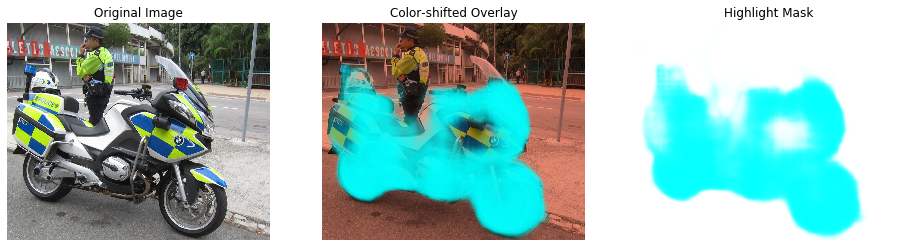

In [28]:
imarray = np.array(PIL.Image.open(filename)) / 255.0  # Convert image pixels from 0-255 to 0-1
hilitecol = np.array((0.0, 1.0, 1.0, 1.0))  # Cyan, 100% opacity (RGBAlpha 0-1 range)

# Red-shift our image to make the cyan highlights more obvious:
imshifted = imarray.copy()
imshifted[:, :, 1] *= 0.6
imshifted[:, :, 2] *= 0.5

# Construct a mask with alpha channel taken from the model result:
hilitemask = np.tile(hilitecol[np.newaxis, np.newaxis, :], list(imarray.shape[:2]) + [1])
hilitemask[:, :, 3] = prob_mask[target_cls_id, :, :]

# Overlay the two images:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 6))

ax0.imshow(imarray)
ax0.axis("off")
ax0.set_title("Original Image")
ax2.imshow(hilitemask)
ax2.axis("off")
ax2.set_title("Highlight Mask")

ax1.imshow(imshifted)
ax1.imshow(hilitemask)
ax1.axis("off")
ax1.set_title("Color-shifted Overlay")

plt.show()

## Delete the Endpoint

Deployed endpoints are backed by infrastructure (1x`ml.c5.xlarge` in our case, as we requested above) - so we should delete the endpoint when we're finished with it, to avoid incurring continued costs.

In [ ]:
ss_predictor.delete_endpoint()